In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Non-parametric Attention
$$ f(x)=\sum_{i=1}^n softmax(-\frac{1}{2}(x-x_i)^2)y_i $$
In the equation $(x_i,y_i)$ are data points in train set

In [ ]:
x_train = torch.tensor([1.0,2.0,3.0,4.0])
y_train = torch.tensor([1.0,4.0,9.0,16.0])
x_val = torch.tensor([1.5,3.5])

In [ ]:
# repeat the validation x for n_train times
x_val.repeat_interleave(4)

tensor([1.5000, 1.5000, 1.5000, 1.5000, 3.5000, 3.5000, 3.5000, 3.5000])

In [ ]:
# size of X_repeat=>(n_val,n_train)
X_repeat = x_val.repeat_interleave(4).reshape((-1, 4))

In [ ]:
print("X_repeat=\n",X_repeat)
print("x_train=\n",x_train)
print("X_repeat-x_train\n",X_repeat-x_train)

X_repeat=
 tensor([[1.5000, 1.5000, 1.5000, 1.5000],
        [3.5000, 3.5000, 3.5000, 3.5000]])
x_train=
 tensor([1., 2., 3., 4.])
X_repeat-x_train
 tensor([[ 0.5000, -0.5000, -1.5000, -2.5000],
        [ 2.5000,  1.5000,  0.5000, -0.5000]])


In [ ]:
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
attention_weights

tensor([[0.4136, 0.4136, 0.1522, 0.0206],
        [0.0206, 0.1522, 0.4136, 0.4136]])

In [ ]:
# The matrix multiplication here (n_val,n_train)*(n_train,1)=(n_val,1)
y_val_hat = torch.matmul(attention_weights,y_train)
y_val_hat

tensor([ 3.7671, 10.9698])

# Parametric Attention
$$ f(x)=\sum_{i=1}^n softmax(-\frac{1}{2}((x-x_i)w)^2)y_i $$
In the equation $(x_i,y_i)$ are data points in train set (key,value).
$x$ is a query.

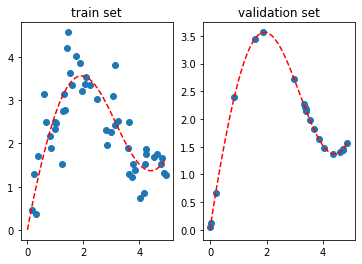

In [ ]:
# Generate dataset
fx = torch.arange(0,5,0.1)
fy = 2 * torch.sin(fx) + fx**0.8

num_train = 50 # Generate train
x_train,_ = torch.sort(torch.rand(num_train)*5)
y_train = 2 * torch.sin(x_train) + x_train**0.8
y_train += torch.normal(0.0, 0.5, (num_train,))

num_val = 20 # Generate validation
x_val,_ = torch.sort(torch.rand(num_val)*5)
y_val = 2 * torch.sin(x_val) + x_val**0.8

plt.subplot(1, 2, 1)
plt.plot(fx,fy,'--r')
plt.scatter(x_train, y_train)
plt.title("train set")

plt.subplot(1, 2, 2)
plt.plot(fx,fy,'--r')
plt.scatter(x_val, y_val)
plt.title("validation set")
plt.show()

In [ ]:
# Prerequisite: bmm=>batch matrix multiplication
X = torch.ones([2,1,2])
Y = torch.ones([2,2,3])
torch.bmm(X,Y).shape


torch.Size([2, 1, 3])

In [ ]:
x = torch.tensor([[1,2],[3,4]])
print(x.shape)
print(x.unsqueeze(1).shape)

torch.Size([2, 2])
torch.Size([2, 1, 2])


In [ ]:
class NWKernelRegression(nn.Module):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

  def forward(self, queries, keys, values):
    num_train = keys.shape[1] # train shape is (num_batch,num_train)
    queries_rep = queries.repeat_interleave(num_train).reshape((-1,num_train))
    self.attention_weights = nn.functional.softmax(-((queries_rep-keys)*self.w)**2/2, dim=1)
    return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)
    

A very neat way to take all combos in a matrix
[1,2,3]=>[1,2],[2,3],[1,3]

In [ ]:
x = torch.tensor([1.0,2.0,3.0,4.0])
x = x.repeat((x.shape[0],1))
print(x)
x_sec = x[(1-torch.eye(x.shape[0])).type(torch.bool)].reshape((x.shape[0],-1))
print(x_sec)

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])
tensor([[2., 3., 4.],
        [1., 3., 4.],
        [1., 2., 4.],
        [1., 2., 3.]])


In [ ]:
X_tile = x_train.repeat((num_train, 1))
keys = X_tile[(1 - torch.eye(num_train)).type(torch.bool)].reshape((num_train, -1))

Y_tile = y_train.repeat((num_train, 1))
values = Y_tile[(1 - torch.eye(num_train)).type(torch.bool)].reshape((num_train, -1))

In [ ]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(),lr=0.5)

for epoch in range(5):
  trainer.zero_grad()
  l = loss(net(x_train,keys,values),y_train)
  l.sum().backward()
  trainer.step()
  print(f'epoch {epoch+1}, loss{float(l.sum()):.6f}')

epoch 1, loss50.563328
epoch 2, loss16.000660
epoch 3, loss15.856702
epoch 4, loss15.747161
epoch 5, loss15.659390


In [ ]:
keys = x_train.repeat((num_val, 1))
values = y_train.repeat((num_val, 1))
y_hat = net(x_val,keys,values)

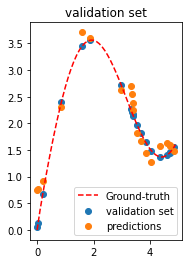

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(fx,fy,'--r',label="Ground-truth")
plt.scatter(x_val, y_val,label="validation set")
plt.scatter(x_val, y_hat.detach(),label="predictions")
plt.title("validation set")
plt.legend()
plt.show()